# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.50KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

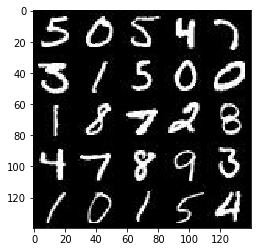

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

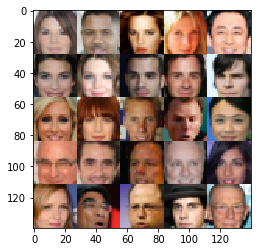

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
#         x1 = tf.layers.conv2d(images, 128, 3, strides=2, kernel_initializer=tf.random_normal_initializer(stddev=0.1), padding='same')
        x1 = tf.layers.conv2d(images, 128, 3, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.1
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*128, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
#         x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)
#         # 28x28x512
        
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * 0.9 ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    show_every = 150
    print_every= 25

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate}
                _ = sess.run(d_opt, feed_dict=feed_dict)
                _ = sess.run(g_opt, feed_dict=feed_dict)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8325... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 2.4893
Epoch 1/2... Discriminator Loss: 1.8476... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 1.4383
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 1.0301


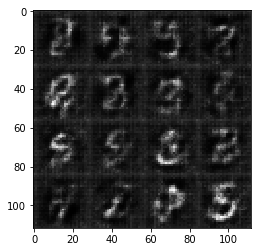

Epoch 1/2... Discriminator Loss: 1.7660... Generator Loss: 0.3151
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 1.5719
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 1.7400... Generator Loss: 0.3369
Epoch 1/2... Discriminator Loss: 1.7089... Generator Loss: 0.3347
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7083


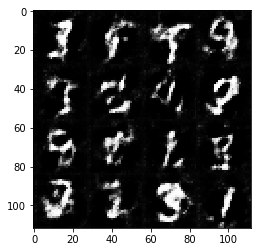

Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.7678
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 1.7124


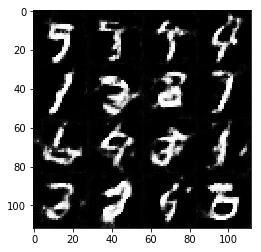

Epoch 1/2... Discriminator Loss: 1.8086... Generator Loss: 0.3289
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.2605
Epoch 1/2... Discriminator Loss: 1.8341... Generator Loss: 0.3114
Epoch 1/2... Discriminator Loss: 1.6593... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.2163


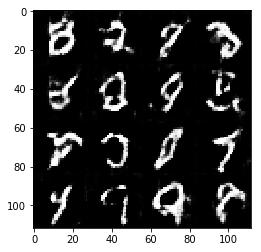

Epoch 1/2... Discriminator Loss: 1.7383... Generator Loss: 0.3302
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 1.7738
Epoch 1/2... Discriminator Loss: 2.3757... Generator Loss: 0.2195


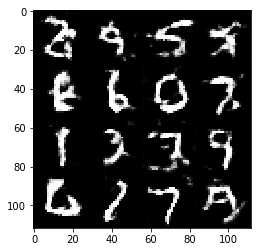

Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.1902
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 1.0992
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 0.9835
Epoch 1/2... Discriminator Loss: 2.8164... Generator Loss: 0.1446
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 0.9401


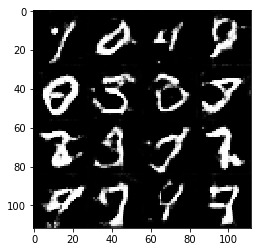

Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 2.4239... Generator Loss: 4.2344
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.6341
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.6740


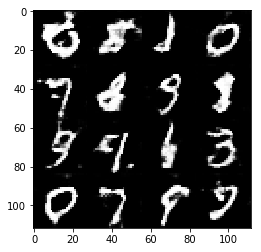

Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 2.1336
Epoch 1/2... Discriminator Loss: 0.5428... Generator Loss: 2.1236
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 1.8414
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 2.4776
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.7823


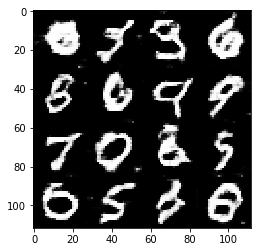

Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 1.9291
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 2.5302
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.3310
Epoch 1/2... Discriminator Loss: 3.8724... Generator Loss: 0.0633
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.1671


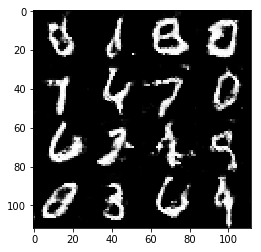

Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.3612
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 1.0749
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 1.1886
Epoch 1/2... Discriminator Loss: 0.5554... Generator Loss: 1.8515
Epoch 1/2... Discriminator Loss: 1.5912... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.5274


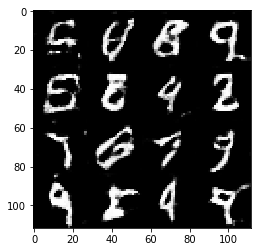

Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.0396
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.8292
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 3.3295
Epoch 1/2... Discriminator Loss: 2.7814... Generator Loss: 0.2108


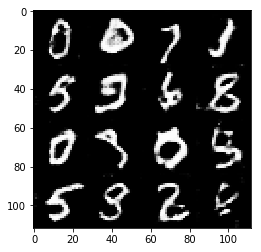

Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.5143
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 1.6759
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 4.1576
Epoch 1/2... Discriminator Loss: 0.6054... Generator Loss: 1.7525
Epoch 1/2... Discriminator Loss: 1.6063... Generator Loss: 3.3860
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.1265


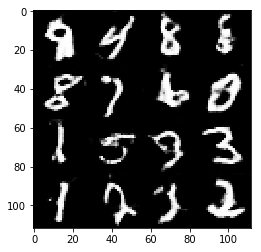

Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 1.6809
Epoch 1/2... Discriminator Loss: 0.5866... Generator Loss: 2.1258
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.7033
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 1.8911
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.1222


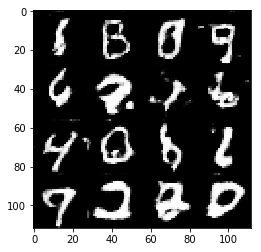

Epoch 2/2... Discriminator Loss: 1.7787... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 0.5848... Generator Loss: 1.8046
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 1.7795
Epoch 2/2... Discriminator Loss: 0.4386... Generator Loss: 2.7679
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 3.4098
Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 2.3313


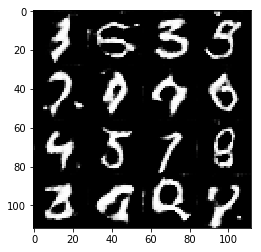

Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.4012
Epoch 2/2... Discriminator Loss: 0.7221... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 2.8965
Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 2.2705
Epoch 2/2... Discriminator Loss: 1.5766... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.7043


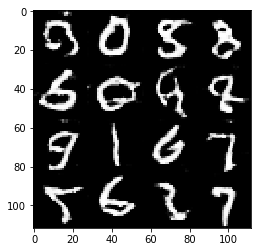

Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 2.1813
Epoch 2/2... Discriminator Loss: 2.0753... Generator Loss: 0.2980
Epoch 2/2... Discriminator Loss: 0.7173... Generator Loss: 1.9397
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 2.3226
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.4762
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 4.0949


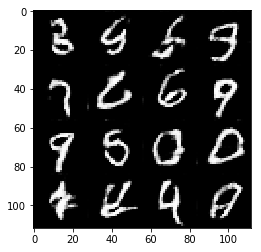

Epoch 2/2... Discriminator Loss: 1.6549... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.6180
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 1.3281
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 2.3850
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 2.0578
Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 3.0578


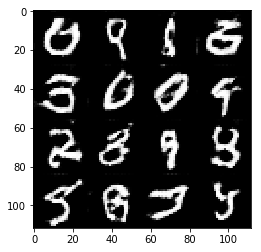

Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 2.9596
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.7471
Epoch 2/2... Discriminator Loss: 0.5190... Generator Loss: 2.4271
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 2.1490
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.8140
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 3.6792


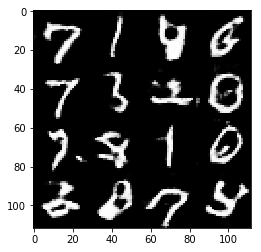

Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.6666
Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 2.1052
Epoch 2/2... Discriminator Loss: 0.4444... Generator Loss: 2.9236
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 2.0884
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 2.1044
Epoch 2/2... Discriminator Loss: 0.4490... Generator Loss: 2.4951


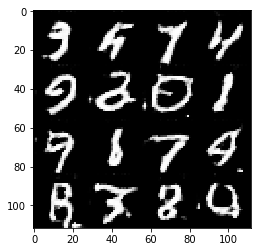

Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 2.5748
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 2.2300
Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.4932
Epoch 2/2... Discriminator Loss: 1.5347... Generator Loss: 4.2897
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 3.4234
Epoch 2/2... Discriminator Loss: 0.4732... Generator Loss: 2.2400


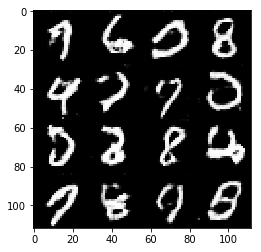

Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.9158
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 2.9178
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.5130
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.7337


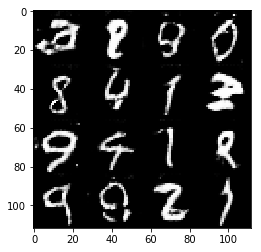

Epoch 2/2... Discriminator Loss: 0.4435... Generator Loss: 2.7152
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.8155
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.7808
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 1.8187
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.4601


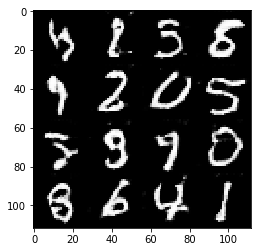

Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 3.0113
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.6403
Epoch 2/2... Discriminator Loss: 0.5617... Generator Loss: 2.6335
Epoch 2/2... Discriminator Loss: 0.6104... Generator Loss: 1.6005
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 1.0313


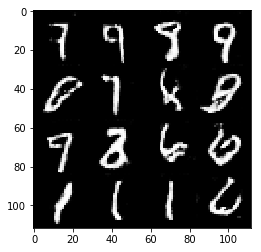

Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.6444
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2724
Epoch 2/2... Discriminator Loss: 2.2084... Generator Loss: 0.4027
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 1.8092
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 2.5478
Epoch 2/2... Discriminator Loss: 0.4919... Generator Loss: 2.3286


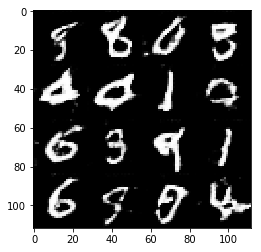

Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 3.2256
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 2.1009
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.3557
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 2.8609
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 2.4985


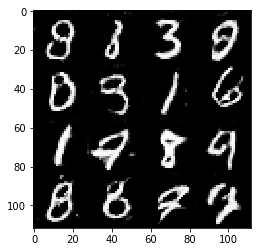

In [58]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1189... Generator Loss: 5.5042
Epoch 1/1... Discriminator Loss: 2.0033... Generator Loss: 2.7852
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 3.2078


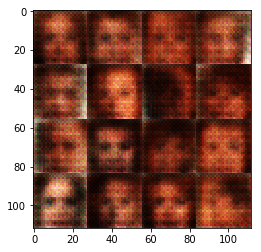

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.7708... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.9535... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.8814


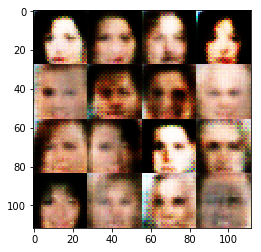

Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.3702
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.1332
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.6513
Epoch 1/1... Discriminator Loss: 2.9151... Generator Loss: 0.1586
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.4743


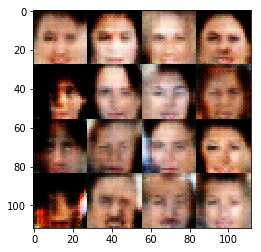

Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 5.2905
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 2.4052... Generator Loss: 0.1658
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 4.1873


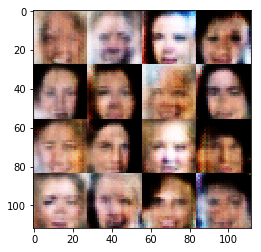

Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 4.0161
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 3.5644
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 2.0087... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 5.3317


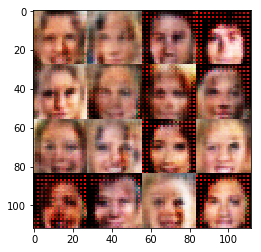

Epoch 1/1... Discriminator Loss: 2.1072... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.5226
Epoch 1/1... Discriminator Loss: 2.0512... Generator Loss: 3.2261
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 2.3016... Generator Loss: 0.2208
Epoch 1/1... Discriminator Loss: 1.8216... Generator Loss: 3.4107


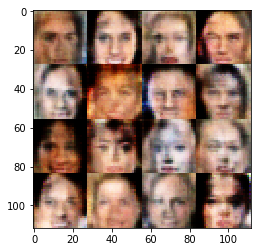

Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.8597
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.4479
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.3998


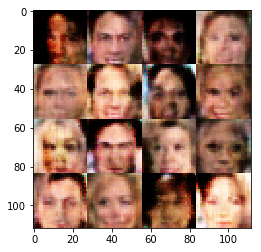

Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 3.8550
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 2.5596
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 2.1362
Epoch 1/1... Discriminator Loss: 1.8541... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.4185


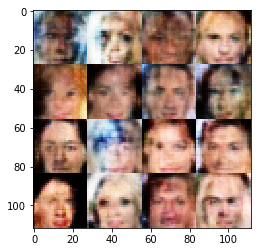

Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 3.5248
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.7854


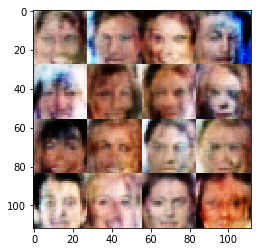

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 3.9004


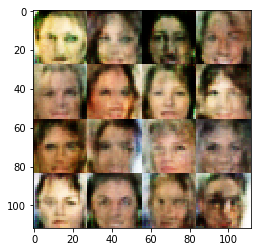

Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 2.7050
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.6215


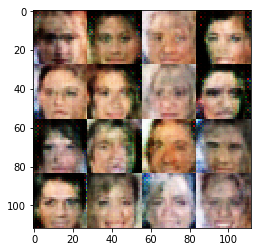

Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 2.3370... Generator Loss: 3.6481
Epoch 1/1... Discriminator Loss: 0.5272... Generator Loss: 1.9525
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.9312


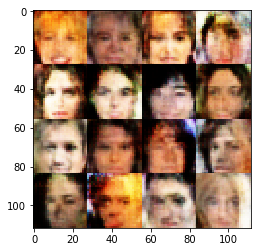

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 2.2289
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.5107


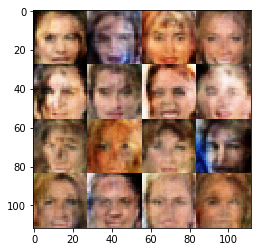

Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.3733


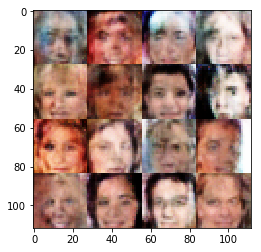

Epoch 1/1... Discriminator Loss: 2.5438... Generator Loss: 0.1522
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 1.9273
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.7884
Epoch 1/1... Discriminator Loss: 2.0258... Generator Loss: 2.1985


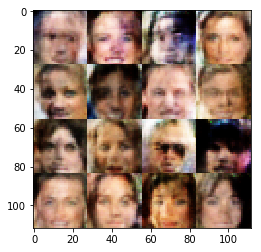

Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 2.3448... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6797


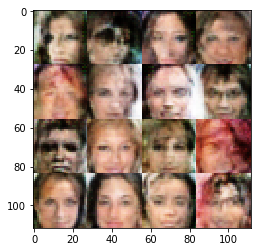

Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.2947
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.7970


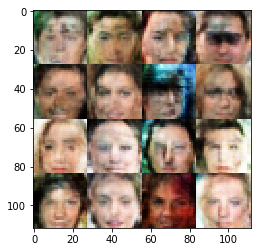

Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6442


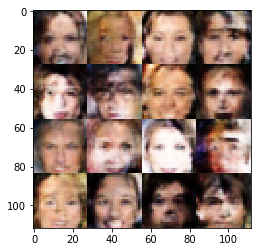

Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.8519


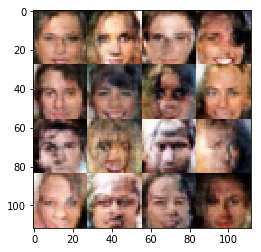

Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 2.3507
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.3365


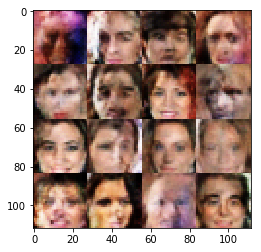

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.3309
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.6201


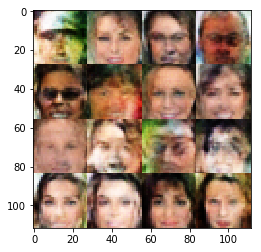

Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.7912


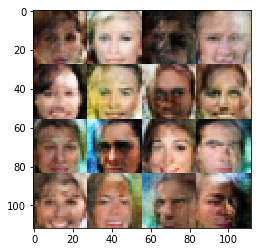

Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 2.1857... Generator Loss: 0.1956
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.5844


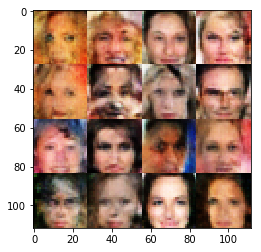

Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7437


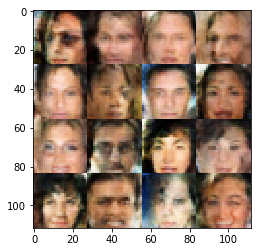

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 2.1161
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0492


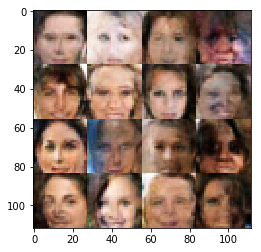

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.1437


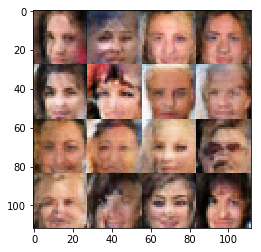

Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.6762


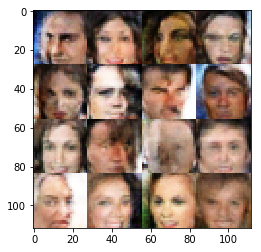

Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 0.3156
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.4822
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.4803


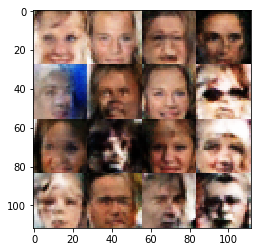

Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9423


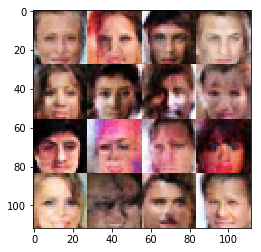

Epoch 1/1... Discriminator Loss: 2.3018... Generator Loss: 3.5169
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.8151... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.0196


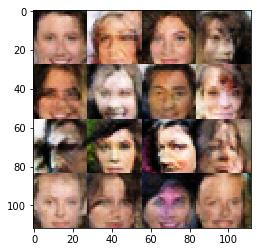

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.7911... Generator Loss: 2.1555


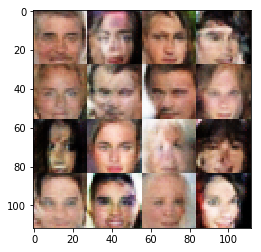

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.7397... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.7909


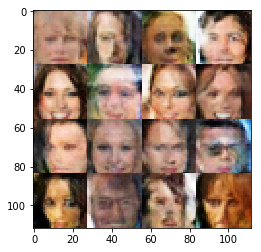

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 1.6688
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.5375


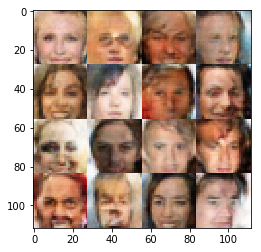

Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.7662


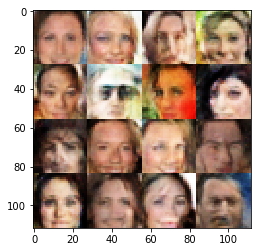

Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 2.6587
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6524


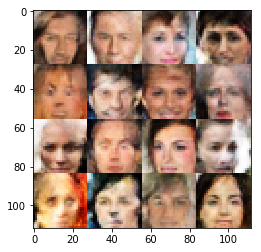

Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.6543
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9534


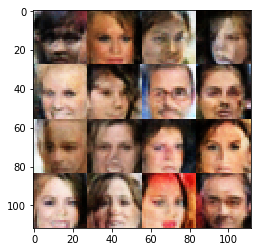

Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 1.8344... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 2.5114... Generator Loss: 0.1905


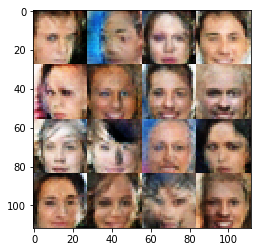

Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4938


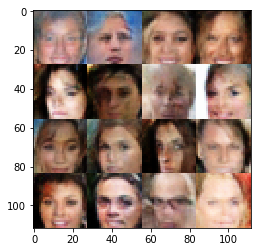

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0970


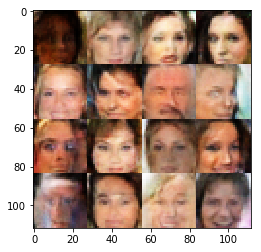

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 1.9215... Generator Loss: 2.5373
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.4802


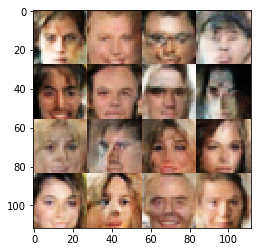

Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 2.9645... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 2.4338


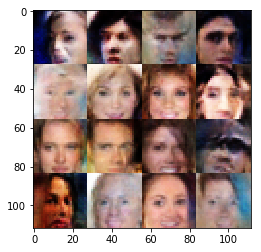

Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9466


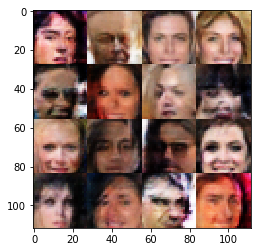

Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 2.1489


In [59]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.